In [20]:
# Set directory to store-sales-time-series-forecasting
import os
import pandas as pd
import numpy as np


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#os.chdir('./store-sales-time-series-forecasting')


In [21]:
import statsmodels
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [22]:
#import train and test data
train = pd.read_csv('train.csv', index_col=['date'], parse_dates=['date'])
test = pd.read_csv('test.csv')

#import stores data
stores = pd.read_csv('stores.csv')

#import holidays data
holidays = pd.read_csv('holidays_events.csv')

#import oil data
oil = pd.read_csv('oil.csv')

#import transactions data
transactions = pd.read_csv('transactions.csv')


In [23]:
train.tail()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148
2017-08-15,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
2017-08-15,3000887,9,SEAFOOD,16.000,0


In [24]:
# visualise train data, color by store
# train.groupby('store_nbr').plot(y='sales', figsize=(15, 10))



In [25]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [26]:
# print the unique values in the family column
print(train['family'].unique())

['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


In [27]:
# take out rows of train with store == 1
train_1 = train[train['store_nbr'] == 1]

In [28]:
train_1.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [29]:
#show train_1 sorted by sales
train_1.sort_values(by='sales', ascending=False)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2016-04-18,2138412,1,GROCERY I,9065.000,18
2016-04-19,2140194,1,GROCERY I,8221.000,19
2015-12-15,1917443,1,FROZEN FOODS,5608.718,0
2016-04-20,2141976,1,GROCERY I,5438.000,28
2016-12-23,2582130,1,GROCERY I,5386.000,125
...,...,...,...,...,...
2014-08-16,1053193,1,SCHOOL AND OFFICE SUPPLIES,0.000,0
2014-08-16,1053189,1,PLAYERS AND ELECTRONICS,0.000,0
2014-08-16,1053188,1,PET SUPPLIES,0.000,0


In [30]:
# show train_1 rows where sales == 0
train_1[train_1['sales'] == 0]

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0
...,...,...,...,...,...
2017-08-14,2997355,1,SCHOOL AND OFFICE SUPPLIES,0.0,0
2017-08-15,2999107,1,BABY CARE,0.0,0
2017-08-15,2999110,1,BOOKS,0.0,0


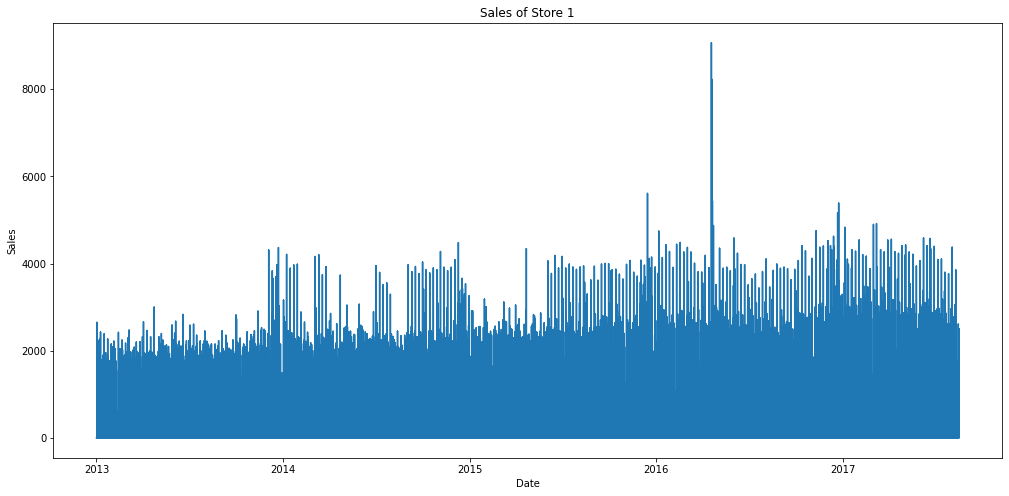

In [31]:

plt.figure(figsize=(17, 8))
plt.plot(train_1.sales)
plt.title('Sales of Store 1')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(False)
plt.show()



 

In [32]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

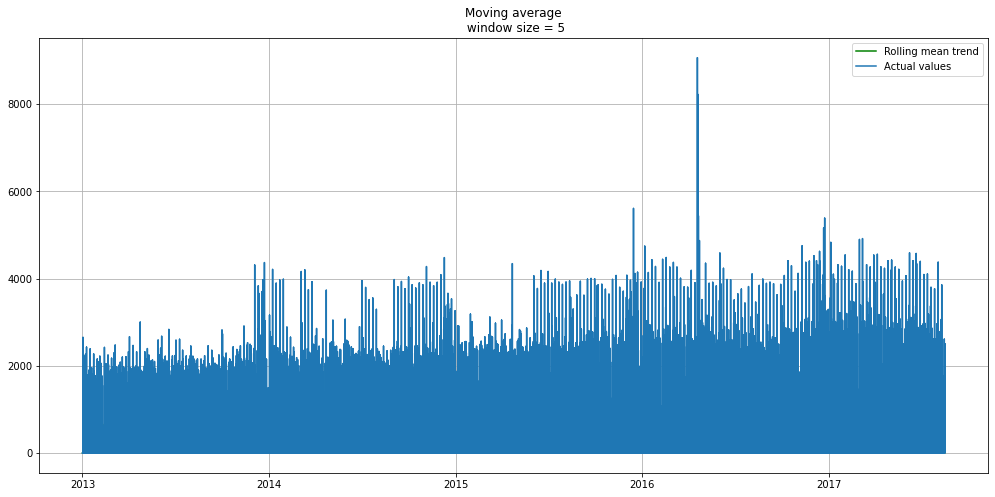

In [33]:
#Smooth by the previous 5 days (by week)
plot_moving_average(train_1.sales, 5)

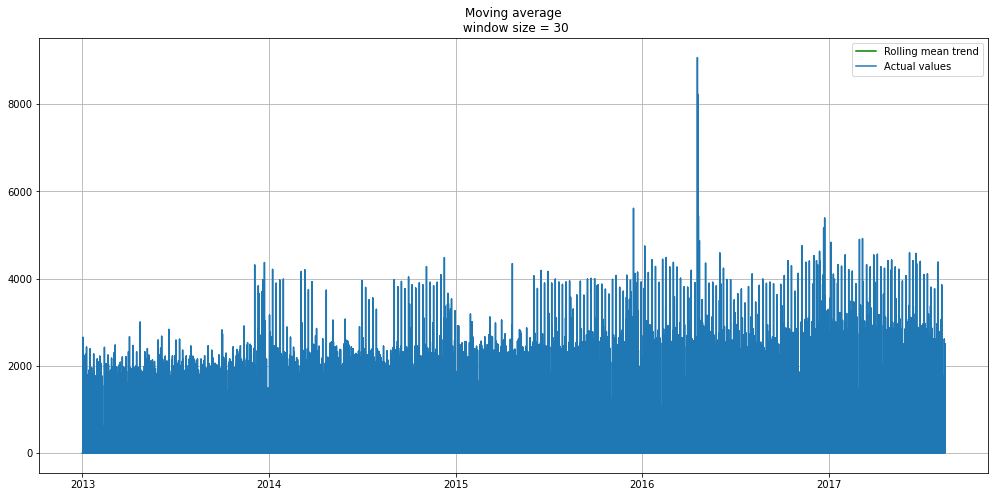

In [34]:
#Smooth by the previous month (30 days)
plot_moving_average(train_1.sales, 30)

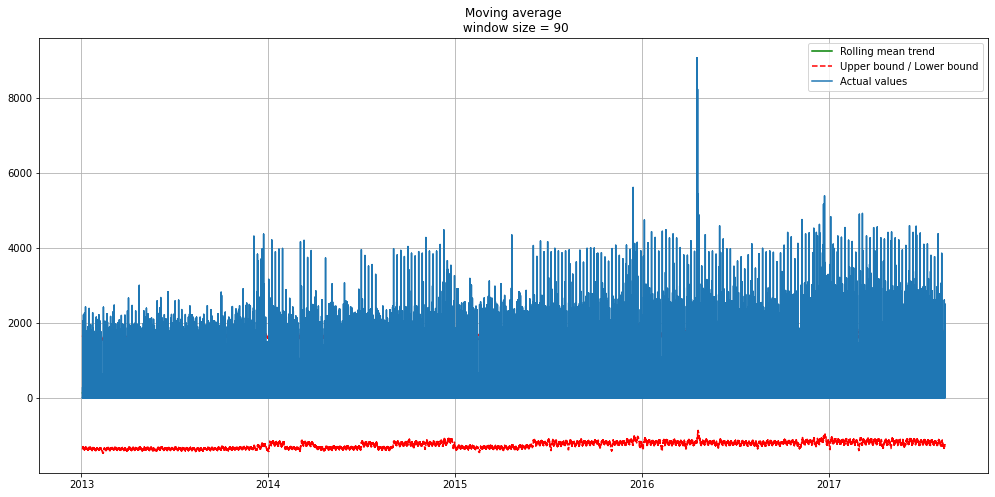

In [35]:
plot_moving_average(train_1.sales, 90, plot_intervals=True)

In [36]:
# group train_1 by date, summing the sales
train_1_daily = train_1.groupby('date')['sales'].sum().reset_index()

In [37]:
train_1_daily.head()

,date,sales
0,2013-01-01,0.000000
1,2013-01-02,7417.148000
2,2013-01-03,5873.244001
3,2013-01-04,5919.879001
4,2013-01-05,6318.785010


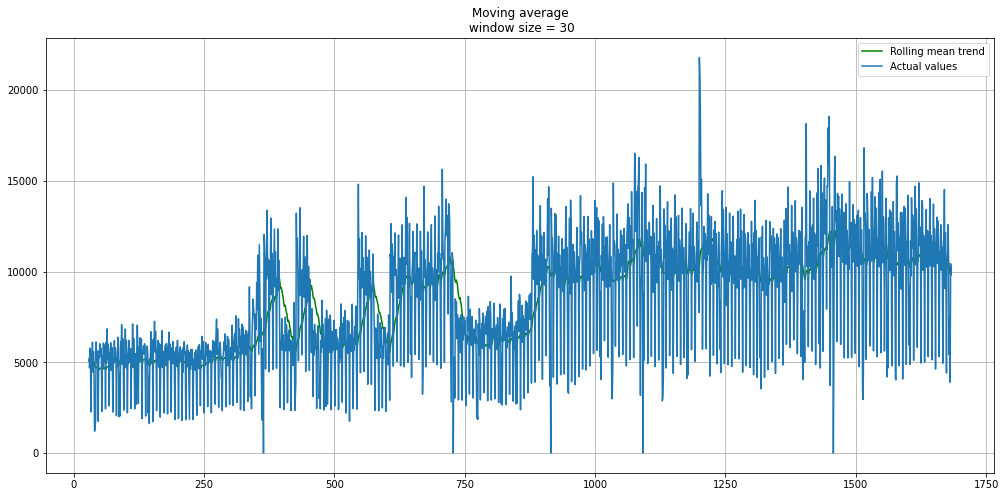

In [38]:
#Smooth by the previous month (30 days)
plot_moving_average(train_1_daily.sales, 30)

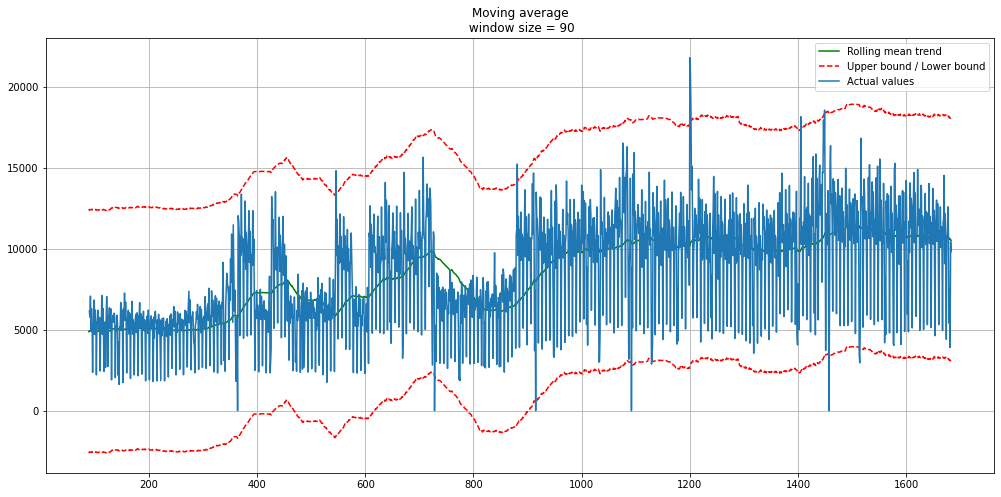

In [39]:
plot_moving_average(train_1_daily.sales, 90, plot_intervals=True)

In [40]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [41]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

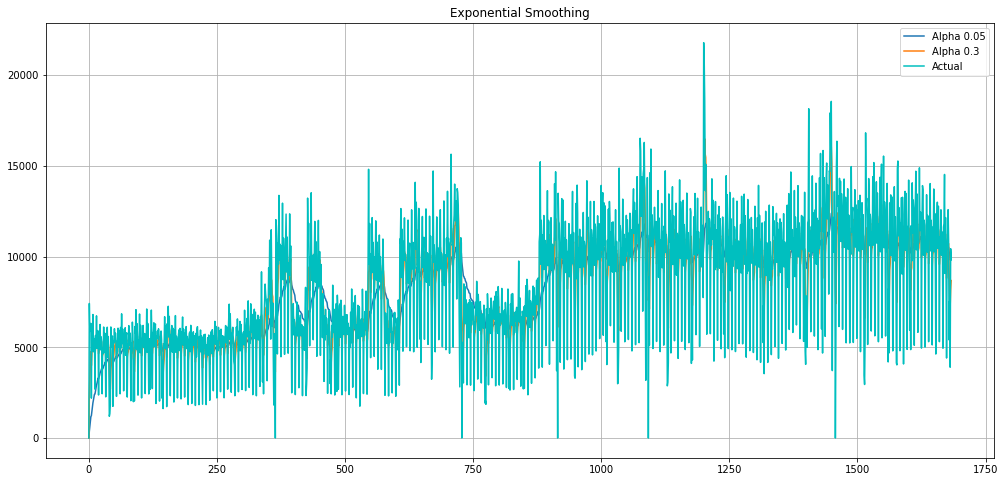

In [42]:
plot_exponential_smoothing(train_1_daily.sales, [0.05, 0.3])

In [43]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [44]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

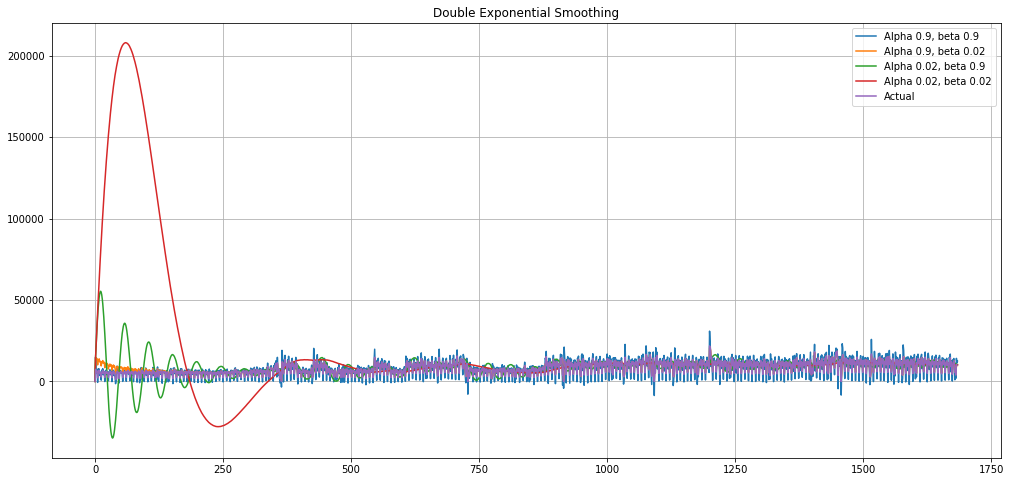

In [45]:
plot_double_exponential_smoothing(train_1_daily.sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


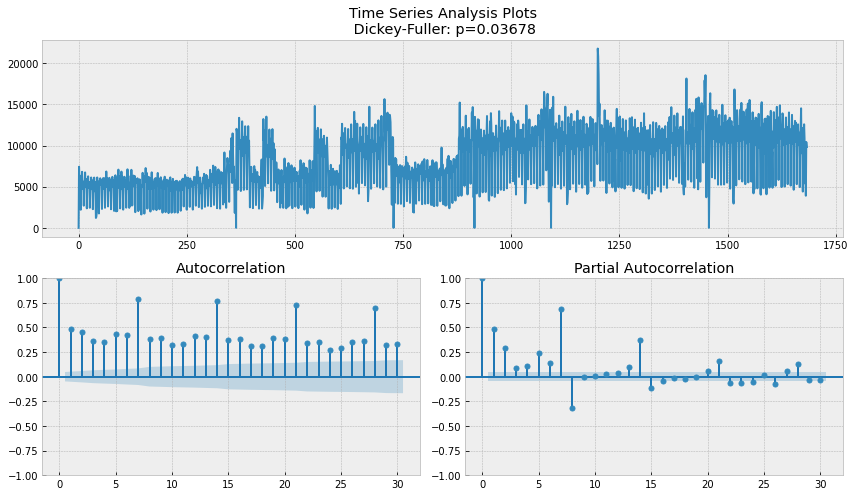

In [46]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(train_1_daily.sales, lags=30)

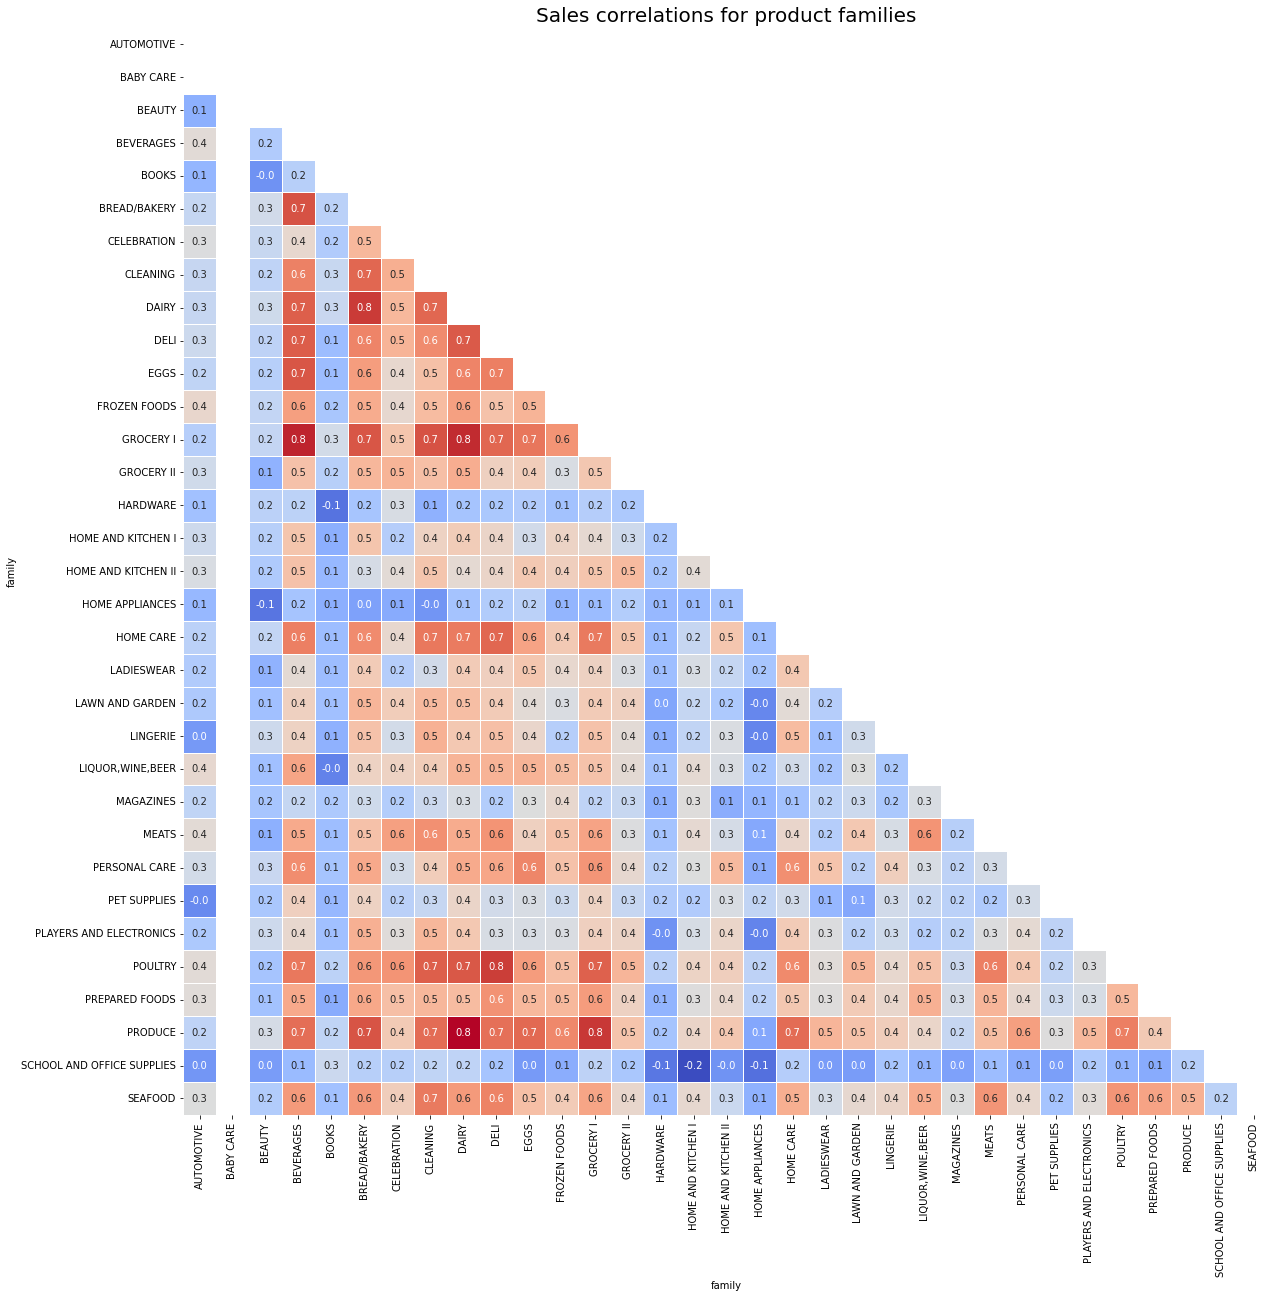

In [52]:
# plot a heatmap of the correlation matrix for family

import seaborn as sns

a = train_1["2017-04-30":].reset_index()
a["ind"] = 1
a["ind"] = a.groupby("family").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "family", values = "sales").corr(method="spearman")
mask = np.triu(a.corr(method="spearman"))
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Sales correlations for product families",fontsize = 20)
plt.show()
